<a href="https://colab.research.google.com/github/BETANCOURT29/AlejandroBetancourt/blob/main/Semana2/limpieza-pandas/SOLUCION_de_Taller_Forecasting_Ocupacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.models import Model


In [187]:
# Cargar dataset de ocupacion de sitios de parqueo
data = pd.read_csv("SJ.csv", header = 0)
data.head()

,date,idCompany,numTrx
0,2022-08,1,68599
1,2022-09,1,86862
2,2022-10,1,99611
3,2022-11,1,109018
4,2022-12,1,115665


In [188]:
# Revisar cabecera y cola del dataset
print("Cabecera del dataset:")
print(data.head())

print("\nCola del dataset:")
print(data.tail())

Cabecera del dataset:
      date  idCompany  numTrx
0  2022-08          1   68599
1  2022-09          1   86862
2  2022-10          1   99611
3  2022-11          1  109018
4  2022-12          1  115665

Cola del dataset:
       date  idCompany  numTrx
13  2023-09          1  126851
14  2023-10          1  137539
15  2023-11          1  145327
16  2023-12          1  135537
17  2024-01          1  148111


In [189]:
# Formatear la columna de fecha como año y mes
data['date'] = pd.to_datetime(data['date'], format='%Y-%m')

data.head()

,date,idCompany,numTrx
0,2022-08-01,1,68599
1,2022-09-01,1,86862
2,2022-10-01,1,99611
3,2022-11-01,1,109018
4,2022-12-01,1,115665


In [190]:
# Verificar el nombre de los meses del dataset para comprobar que el formateo es correcto
meses = data['date'].dt.month_name().unique()

print(meses)

['August' 'September' 'October' 'November' 'December' 'January' 'February'
 'March' 'April' 'May' 'June' 'July']


In [191]:
# Contar el numero de datos del dataset
num_filas = data.shape[0]

print(f"Número total de datos en el dataset: {num_filas}")

Número total de datos en el dataset: 18


In [192]:
# Obtener una estadistica descriptiva básica del dataset, verificar si hay algo anormal
estadisticas = data.describe()

print(estadisticas)

                      date  idCompany         numTrx
count                   18       18.0      18.000000
mean   2023-04-16 18:40:00        1.0  120111.833333
min    2022-08-01 00:00:00        1.0   68599.000000
25%    2022-12-08 18:00:00        1.0  110679.750000
50%    2023-04-16 00:00:00        1.0  125518.500000
75%    2023-08-24 06:00:00        1.0  135321.000000
max    2024-01-01 00:00:00        1.0  148111.000000
std                    NaN        0.0   20840.047288


In [193]:
# Revisar si el ldataset tiene datos nullos
valores_nulos = data.isnull().sum()

print(valores_nulos)

date         0
idCompany    0
numTrx       0
dtype: int64


In [194]:
# Establecer el campo fecha como index del dataframe
data.set_index('date', inplace=True)

print(data.head())

            idCompany  numTrx
date                         
2022-08-01          1   68599
2022-09-01          1   86862
2022-10-01          1   99611
2022-11-01          1  109018
2022-12-01          1  115665


In [195]:
# Verificar nuevamente el head de la tabla y comprobar que el index ahora sea la fecha
print(data.head())


            idCompany  numTrx
date                         
2022-08-01          1   68599
2022-09-01          1   86862
2022-10-01          1   99611
2022-11-01          1  109018
2022-12-01          1  115665


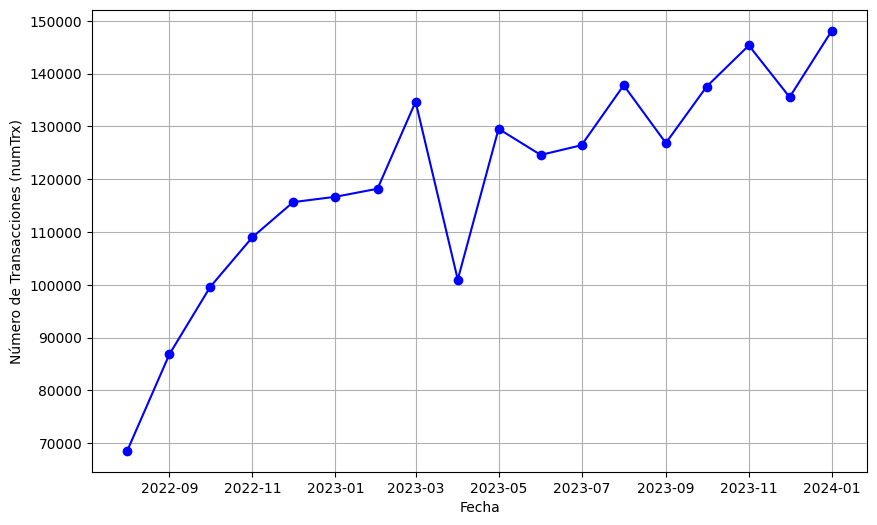

In [196]:
# Realizar una grafica de tendencia del numero de espacios ocupados en el tiempo

plt.figure(figsize=(10,6))
plt.plot(data.index, data['numTrx'], marker='o', linestyle='-', color='b')

plt.xlabel('Fecha')
plt.ylabel('Número de Transacciones (numTrx)')
plt.grid(True)

plt.show()

In [197]:
# Eliminar las columnas que no necesiten para realizar un sistema de prediccion de ocupacion de parqueo
data = data.drop(columns=['idCompany'])

print(data.head())

            numTrx
date              
2022-08-01   68599
2022-09-01   86862
2022-10-01   99611
2022-11-01  109018
2022-12-01  115665


In [198]:
# Escalar entre -1 y 1 los datos de la variable a predecir
scaler = MinMaxScaler(feature_range=(-1, 1))

data['numTrx_scaled'] = scaler.fit_transform(data[['numTrx']])

print(data[['numTrx', 'numTrx_scaled']].head())

            numTrx  numTrx_scaled
date                             
2022-08-01   68599      -1.000000
2022-09-01   86862      -0.540623
2022-10-01   99611      -0.219942
2022-11-01  109018       0.016677
2022-12-01  115665       0.183872


In [199]:
# Definir una ventana temporal adecuada para la prediccion y establecer las listas
# xtrain y ytrain para el entrenamiento
window_size = 2
xtrain = []
ytrain = []

for i in range(window_size, len(data)):
    xtrain.append(data['numTrx_scaled'].values[i-window_size:i])
    ytrain.append(data['numTrx_scaled'].values[i])

xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

print("xtrain shape:", xtrain.shape)
print("ytrain shape:", ytrain.shape)

xtrain shape: (16, 2)
ytrain shape: (16,)


In [200]:
# Convertir las listas en arrays de numpy
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

print("xtrain shape:", xtrain.shape)
print("ytrain shape:", ytrain.shape)

xtrain shape: (16, 2)
ytrain shape: (16,)


In [201]:
# Verificar el shape de los datos de entrenamiento (variable independiente y dependiente)
print("Shape de xtrain (variable independiente):", xtrain.shape)
print("Shape de ytrain (variable dependiente):", ytrain.shape)

Shape de xtrain (variable independiente): (16, 2)
Shape de ytrain (variable dependiente): (16,)


In [202]:
# Construir un modelo LSTM para realizar la predicción que tenga la siguiente arquitectura

# Una capa LSTM de 256 neuronas con activación relu
# Una capa LSTM de 256 neuronas con activación relu
# Una capa LSTM de 128 neuronas con activación relu
# Una capa LSTM de 64 neuronas con activación relu
# Una capa LSTM de 32 neuronas con activación relu
# Una capa LSTM de 16 neuronas con activación relu (esta seria la ultima capa LSTM)
# Agregar operaciones de Dropout de 7% despues de cada capa LSTM
# Agregar en la etapa final una red densa con dos capas con 64 neuronas y 32 neuronas
# Finalmente agregar una capa densa de salida
# Imprimir el summary del  modelo
model = Sequential()

model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(xtrain.shape[1], 1)))
model.add(Dropout(0.07))

model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.07))

model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.07))

model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.07))

model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.07))

model.add(LSTM(16, activation='relu'))
model.add(Dropout(0.07))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                       │ (None, 2, 256)              │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_45 (LSTM)                       │ (None, 2, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_46 (LSTM)                       │ (None, 2, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_47 (LSTM)                       │ (None, 2, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_48 (LSTM)                       │ (None, 2, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_49 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,054,785 (4.02 MB)

 Trainable params: 1,054,785 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [203]:
# Compilar el modelo con una funcion de error mse y un optimizador adam
model.compile(optimizer='adam', loss='mean_squared_error')

print("Modelo compilado con éxito.")

Modelo compilado con éxito.


In [204]:
# Entrenar el modelo durante 100 epocas
# Usar el 10% de los datos de entrenamiento para validacion
# Usar un batch size de 16
history = model.fit(
    xtrain,
    ytrain,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.2490 - val_loss: 0.7266
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 0.2459 - val_loss: 0.7173
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2418 - val_loss: 0.7078
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2377 - val_loss: 0.6983
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2337 - val_loss: 0.6885
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2295 - val_loss: 0.6785
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.2253 - val_loss: 0.6686
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2212 - val_loss: 0.6583
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2170 - val_loss: 0.6480
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2128 - val_loss: 0.6378
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.2088 - val_loss: 0.6272
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2046 - 

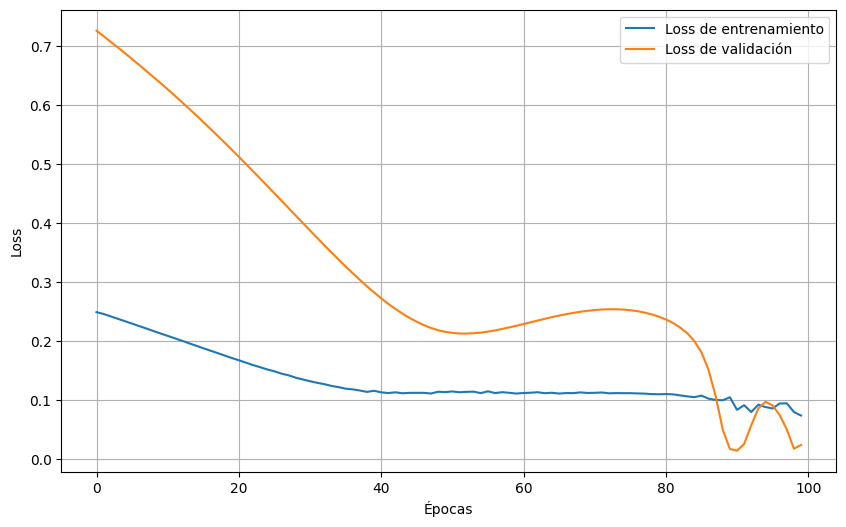

In [205]:
# Grafifcar el loss y loss de validacion para verificar que no haya overfitting
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,6))
plt.plot(loss, label='Loss de entrenamiento')
plt.plot(val_loss, label='Loss de validación')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [206]:
# Guardar el modelo y salvarlo en disco
model.save('modelo_lstm_prediccion.h5')


In [207]:
# Tome N registros historicos de su dataset y realice la predicción de ocupación para un mes particular
window_size = 2

historical_data = data['numTrx_scaled'].values[-(window_size + 1):-1]

historical_data = historical_data.reshape((1, window_size, 1))

prediccion = model.predict(historical_data)

print("Predicción escalada:", prediccion)

prediccion_desescalada = scaler.inverse_transform(prediccion)
print("Predicción desescalada (número de transacciones):", prediccion_desescalada)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
Predicción escalada: [[1.0422182]]
Predicción desescalada (número de transacciones): [[149789.42]]


In [208]:
valor_real = data['numTrx'].values[-1]

prediccion_desescalada_valor = prediccion_desescalada[0][0]

print(f"Predicción desescalada: {prediccion_desescalada_valor:.2f}")
print(f"Valor real: {valor_real}")
print(f"Diferencia: {abs(prediccion_desescalada_valor - valor_real):.2f}")

Predicción desescalada: 149789.42
Valor real: 148111
Diferencia: 1678.42


In [211]:
# Proponga una arquitectura que permita recibir como parametros de entrada no solo los historicos de la
# serie temporal sino tambien información adicional relevante como por ejemplo el mes para el cual se
# realiza la predicción, o el número de dias festivos del mes de predicción
